# 使用`pmdarima`自动进行`ARIMA`时间序列分析

以年份为例,里面有`缺失值补全`。本例有关于`指数平滑`的演示`exponential_smoothing.ipynb`

In [14]:
import numpy as np
import pandas as pd
import pmdarima as pm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## 加载数据

大致的数据分析可以看看`plotMovingAverage.ipynb`

In [19]:
df = pd.read_csv("./data/complex-PUB-expand.csv")
df = df[df["Country"] == "DNK"]
df = pd.melt(df,id_vars=["Country"],var_name="Year",value_name="Value") # 列转行
# df["Year"] = df["Year"].astype("datetime64[ns]")
df = df.drop(columns=["Country"])
df.head()

,Year,Value
0,1995,99.40405
1,2000,97.61373
2,2005,96.70573
3,2008,93.34492
4,2009,92.97375


## 根据时间段补全时间段

In [20]:
# 补全时间数据
startYear = 2007
endYear = 2018 # 不要超过Years[-1]

Years = list(map(int,df["Year"])) # 升序
Values = list(df["Value"])
YearsCopy = Years.copy()
Years = [year for year in Years if year >= startYear and year <= endYear]
Values = [Values[YearsCopy.index(year)] for year in Years]
intervals = endYear - startYear + 1


Years.extend([0 for _ in range(intervals - len(Years))]) # 方便后续插入
Values.extend([0 for _ in range(intervals - len(Values))])

YEARS = [year for year in range(startYear,endYear+1)] # 注意df中year的类型转化为了int
miss = [year for year in YEARS if year not in Years]
for misYear in miss: # 插入缺失年份
    i  = 0 
    while misYear >= Years[i]:
        i += 1
    for j in range(len(Years)-2,i-1,-1):
        Years[j+1] = Years[j]
        Values[j+1] = Values[j]
    Years[i] = misYear
    Values[i] = np.nan
tsData = pd.DataFrame(dict(Year=Years,Values=Values))
tsData["Year"] = tsData["Year"].map(str) # 要先转化为字符串才能接下来正确转化为时间
tsData["Year"] = pd.to_datetime(tsData["Year"])
tsData

,Year,Values
0,2007-01-01,NaN
1,2008-01-01,93.34492
2,2009-01-01,92.97375
3,2010-01-01,92.26746
4,2011-01-01,91.78908
5,2012-01-01,NaN
6,2013-01-01,90.29342
7,2014-01-01,92.34969
8,2015-01-01,NaN
9,2016-01-01,86.21557


## 补全缺失值

In [21]:
tsData = tsData.set_index("Year")
tsData.interpolate(method="time")
tsData = tsData.dropna() # 去掉开头的空值
tsData

# import pickle
# with open("pmdarima-year.pkl","wb") as f:
#     pickle.dump(tsData,f)

,Values
Year,
2008-01-01,93.34492
2009-01-01,92.97375
2010-01-01,92.26746
2011-01-01,91.78908
2013-01-01,90.29342
2014-01-01,92.34969
2016-01-01,86.21557
2017-01-01,83.15323
2018-01-01,81.97565


In [5]:
arima = pm.auto_arima(tsData["Values"]) # 如果有时间周期,可以设置m值，变为SARIMA模型(如是小时数据，设置m=24)
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    9
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -21.927
Date:                Mon, 14 Feb 2022   AIC                             49.853
Time:                        22:03:45   BIC                             50.445
Sample:                             0   HQIC                            48.576
                                  - 9                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.6296     31.999      0.332      0.740     -52.087      73.346
ar.L1          0.8798      0.363      2.421      0.015       0.168       1.592
sigma2         6.4245      4.689      1.370      0.1

## 拟合程度对比

区间为`置信区间`

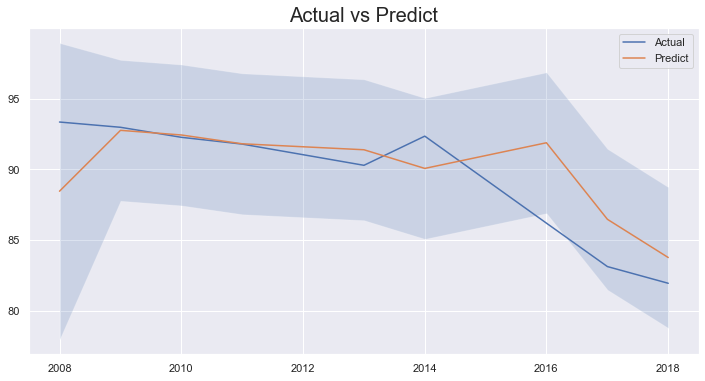

In [7]:
pred,confident = arima.predict_in_sample(return_conf_int=True)
tsData["pred"] = pred
tsData["con_l"] = confident[:,0]
tsData["con_h"] = confident[:,1]

plt.figure(figsize=(12,6))
plt.title("Actual vs Predict",fontsize=20)
plt.plot(tsData["Values"],label="Actual")
plt.plot(tsData["pred"],label="Predict")
plt.fill_between(tsData.index,tsData["con_l"],tsData["con_h"],alpha=.2)
plt.legend()

## 预测数据

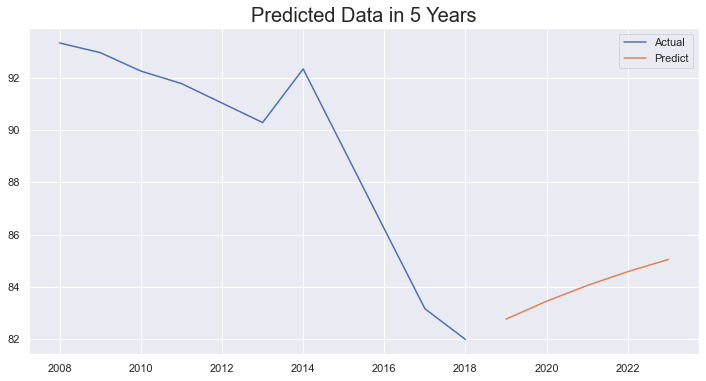

In [10]:
prLen = 5 # 以预测5年为例
# 这里不用datetime.timedelta是因为不支持加年
startYear = tsData.index[-1].year + 1
endYear = startYear + prLen - 1# 其实endYear本来就是这个值
prYears = [year for year in range(startYear,endYear + 1)]
predictVal = arima.predict(prLen)

pred = pd.DataFrame(dict(Year=prYears,Values=predictVal))
pred["Year"] = pred["Year"].map(str) # 要先转化为字符串才能接下来正确转化为时间
pred["Year"] = pd.to_datetime(pred["Year"])
pred = pred.set_index("Year")

plt.figure(figsize=(12,6))

plt.title("Predicted Data in {} Years".format(prLen),fontsize=20)
plt.plot(tsData["Values"],label="Actual")
plt.plot(pred["Values"],label="Predict")
plt.legend()